In [46]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
sys.path.insert(0, '..')
from pyecca.sim.simpy_sim import Core, KinematicSim, Logger, Node
import pyecca.sim.msgs as msgs
import numpy as np

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
class Estimator(Node):

    def __init__(self, core, funcs):
        super().__init__(core)
        self.funcs = funcs

        # subscriptions
        self.mag_sub = core.subscribe('mag', self.mag_callback)
        self.imu_sub = core.subscribe('imu', self.imu_callback)

        self.x = np.zeros(6)
        self.W = np.zeros((6, 6))

    def mag_callback(self, msg: msgs.Mag):
        y = np.array([msg.x, msg.y, msg.z])
        p = self.core.params
        x1, W1, beta, r, r_std, ret = self.funcs['correct_mag'](
            self.x, self.W, y,
            p['decl'], p['std_mag'], p['beta_mag_c'])

    def imu_callback(self, msg: msgs.Imu):
        dt = 1.0/200  # TODO based on callback rate
        p = self.core.params
        y = np.array([msg.ax, msg.ay, msg.az])
        omega = np.array([msg.gx, msg.gy, msg.gz])
        x1, W1, beta, r, r_std, ret = self.funcs['correct_accel'](
            self.x, self.W, y, omega,
            p['std_accel'], p['std_accel_omega'], p['beta_accel_c'])
        self.funcs['predict_x_W'](self.x, self.W, omega,
                                  p['std_gyro'], p['sn_gyro_rw'], dt)


In [48]:
# load simulation functions
pkl_path = os.path.join('../examples/sim_funcs.pkl')
with open(pkl_path, 'rb') as f:
    funcs = pickle.load(f)

core = Core()
core.params = {
    'std_mag': 2.5e-3,
    'decl': 0,
    'incl': 1,
    'beta_mag_c': 6.2,
    'std_accel': 35e-3,
    'std_accel_omega': 100e-3,
    'std_gyro': 1e-3,
    'sn_gyro_rw': 0.01e-3,
    'beta_accel_c': 9.6,
    'tf': 10,
}
sim = KinematicSim(core, funcs)
estimator = Estimator(core, funcs)
logger = Logger(core)
core.run(until=core.params['tf'])
data = logger.write()

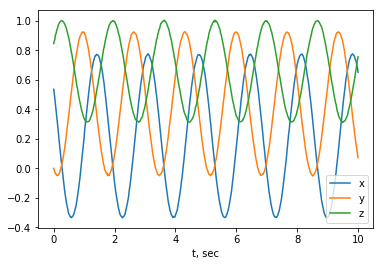

In [49]:
data['mag'].plot()

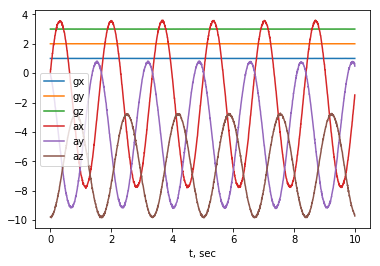

In [50]:
data['imu'].plot()